### Importation

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### On télécharge les données

In [ ]:
# import zipfile
# !curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
# with zipfile.ZipFile("./captcha_images_v2.zip", "r") as zip_ref:
#     zip_ref.extractall("../data/")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

 40 8863k   40 3625k    0     0  2613k      0  0:00:03  0:00:01  0:00:02 2613k
100 8863k  100 8863k    0     0  5546k      0  0:00:01  0:00:01 --:--:-- 24.3M


Ce code sert à préparer le dataset CAPTCHA pour l’OCR :
- localiser les images
- extraire les labels (le texte du CAPTCHA)
- analyser les caractères possibles
- définir les paramètres clés pour le modèle CNN + RNN + CTC

Le batch size, c’est le nombre d’exemples traités en même temps par le réseau avant de mettre à jour les poids.

Le modèle prend batch_size images

- Il fait le forward pass
- Il calcule la loss
- Il fait le backpropagation
- Il met à jour les poids
- Puis il passe au batch suivant

Le facteur de sous-échantillonnage "downsample_factor" correspond à la réduction spatiale induite par les couches convolutionnelles et de pooling. Il détermine la longueur de la séquence traitée par le réseau récurrent.”

In [ ]:
# Path to the data directory
data_dir = Path("../data/captcha_images_v2/")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

Number of images found:  0
Number of labels found:  0
Number of unique characters:  0
Characters present:  set()


ValueError: max() arg is an empty sequence

### Preprocessing Dataset

encoder les caractères, Les réseaux de neurones ne comprennent que des nombres.

In [11]:
# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)

décoder les prédictions, Pour lire la sortie du modèle et afficher le texte prédit

In [12]:
# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

séparer train / validation (il faudra faire un test plus tard)

In [13]:
def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


encode_single_sample =  préparer UNE image, Elle transforme une image brute + son texte en entrée utilisable par le modèle.

In [14]:

def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

### Transformer les données brutes (chemins d’images + labels) en datasets TensorFlow optimisés, prêts pour l’entraînement du modèle OCR.


- Transformation des images et labels d’entraînement en un Dataset TensorFlow.
- Application automatique du prétraitement sur chaque échantillon.
- Regroupement des données en batchs pour l’entraînement.
- Préchargement des données afin d’optimiser les performances.
- Création d’un dataset de validation suivant le même pipeline.


**À quoi sert TensorFlow (en général)**

TensorFlow est une bibliothèque qui permet de :

- créer des réseaux de neurones
- gérer les calculs numériques lourds
- entraîner des modèles efficacement (CPU / GPU)
- déployer des modèles en production

Sans TensorFlow, on ferai tout ça à la main (impossible en pratique).

**À quoi sert TensorFlow dans le projet CAPTCHA**

Dans ce projet, TensorFlow est utilisé pour :

Construire le modèle OCR
- CNN : extraction des formes visuelles
- RNN : lecture séquentielle des caractères
- CTC Loss : apprentissage sans segmentation explicite

Ces composants sont fournis par TensorFlow / Keras.

---

Gérer les données efficacement
- tf.data.Dataset
- batching
- prefetching

Permet un entraînement plus rapide et une meilleure gestion de la mémoire.

---

Entraîner le modèle
- calcul de la fonction de perte (loss)
- backpropagation
- mise à jour des poids

TensorFlow gère automatiquement les calculs mathématiques complexes.

---

Faire des prédictions
- chargement d’une image CAPTCHA
- prédiction du texte
- décodage de la sortie du modèle

Site web
↓
Scraping (Selenium)
↓
Image CAPTCHA
↓
TensorFlow (OCR)
↓
Texte reconnu
↓
Remplissage automatique




In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

### Visualiser les data

In [ ]:

_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

### Creation du modèle d'OCR


- **CTC Layer**
  - Calcule automatiquement la CTC Loss pendant l’entraînement.
  - Permet d’apprendre sans segmentation explicite des caractères.

- **Entrées du modèle**
  - Image CAPTCHA en entrée.
  - Label texte utilisé uniquement pour le calcul de la loss.

- **Extraction visuelle (CNN)**
  - Les couches convolutionnelles détectent les formes et motifs visuels.
  - Les couches de pooling réduisent la taille de l’image et concentrent l’information.

- **Transformation image → séquence**
  - Les features visuelles sont réorganisées pour être lues comme une séquence.
  - La largeur de l’image devient la dimension temporelle.

- **Traitement séquentiel (RNN)**
  - Les LSTM bidirectionnels analysent la séquence de gauche à droite et inversement.
  - Le contexte global aide à mieux reconnaître les caractères.

- **Couche de sortie**
  - Prédiction des probabilités de chaque caractère (et du symbole blank) à chaque pas de temps.

- **CTC Loss**
  - Aligne automatiquement la séquence prédite avec le texte cible.
  - Gère les longueurs variables des CAPTCHA.

- **Compilation du modèle**
  - Optimisation avec Adam.
  - Le modèle est prêt pour l’entraînement avec `model.fit()`.

- **Pipeline global**
  - Image → CNN → Séquence → RNN → Prédictions → CTC Loss


In [ ]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(len(characters) + 1, activation="softmax", name="dense2")(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

### Train the Neural Network

In [ ]:

epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

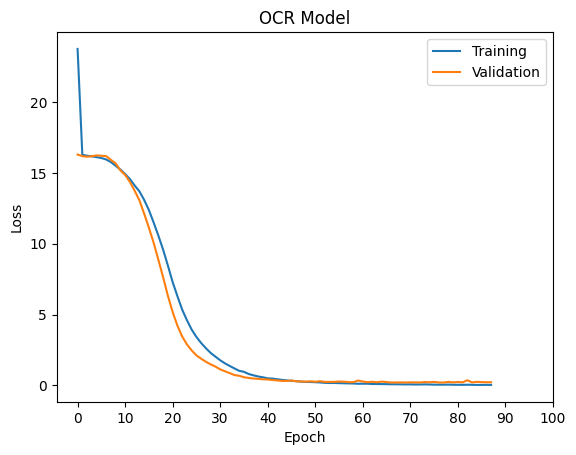

In [41]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xticks(range(0,epochs+1,10))
plt.title("OCR Model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Training","Validation"],loc="upper right")

**Ce que montre le graphique**

- Axe X : epochs (itérations d’entraînement)
- Axe Y : valeur de la CTC Loss
- Bleu : entraînement
- Orange : validation

1. Début : loss très élevée (normal)

Au début :

- le modèle ne comprend rien
- il prédit presque au hasard
- la CTC Loss est donc très grande

C’est 100 % normal.

2. Chute rapide de la loss (excellent signe)

Entre ~epoch 8 et 15 :

- la loss s’effondre
- le modèle commence à :
    - reconnaître les formes
    - aligner image ↔ texte
    - utiliser correctement les blanks

 C’est le moment où CTC “clique”.

3. Train et validation suivent la même courbe 

C’est le point le plus important :

- les deux courbes sont très proches
- aucune divergence
- pas d’overfitting
- bonne généralisation

pipeline correct (données, labels, modèle)

4. Loss proche de zéro à la fin

À la fin :

- loss ≈ 0 (ou très faible)

Interprétation :

- le modèle arrive presque toujours à produire la bonne séquence
- sur train ET validation

Attention :

- une loss proche de 0 ne garantit pas 100 % d’accuracy
- mais c’est très bon signe en CTC OCR

### Predictions with Trained Neural Network

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 200, 50, 32)       320       
                                                                 
 batch_normalization (Batch  (None, 200, 50, 32)       128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 100, 25, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 25, 64)       18496     
                                                                 
 batch_normalization_1 (Bat  (None, 100, 25, 64)       256 

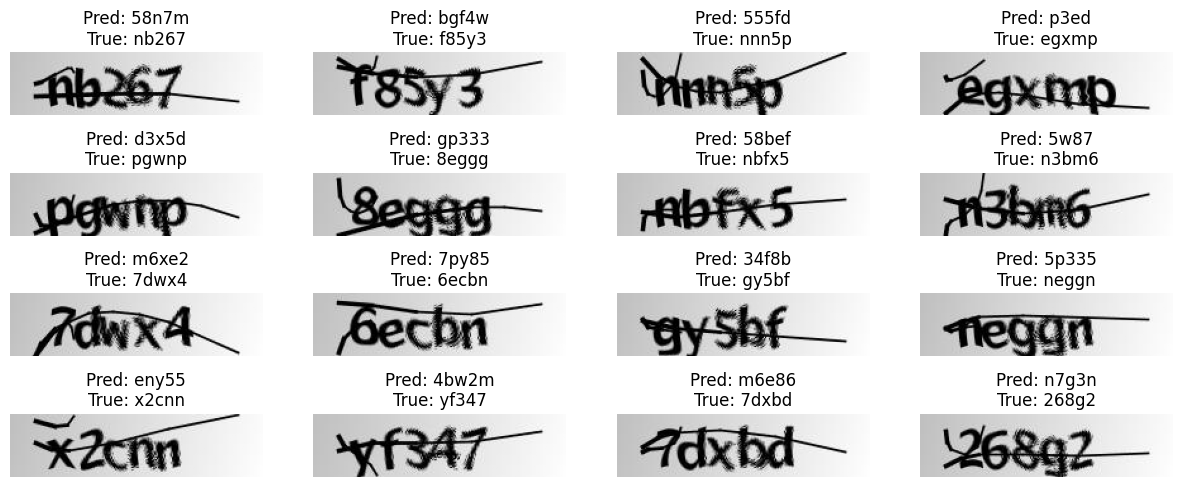

In [ ]:
# ================================
# PREDICTION + AFFICHAGE CORRECT
# ================================

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# -------- Prediction model (sans CTC loss) --------
prediction_model = tf.keras.models.Model(
    model.get_layer(name="image").input,
    model.get_layer(name="dense2").output,
)
prediction_model.summary()


# -------- Image preprocessing (IDENTIQUE à l'entraînement) --------
def preprocess_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, perm=[1, 0, 2])  # largeur = temps (CTC)
    return img


# -------- Dataset de prédiction (ordre garanti) --------
pred_dataset = (
    tf.data.Dataset.from_tensor_slices(x_valid)
    .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(16)
)


# -------- CTC decoding --------
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = tf.keras.backend.ctc_decode(
        pred,
        input_length=input_len,
        greedy=True
    )[0][0][:, :max_length]

    output_text = []
    for res in results:
        text = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        text = text.replace("[UNK]", "")
        output_text.append(text)
    return output_text


# -------- Prediction --------
preds = prediction_model.predict(pred_dataset)
pred_texts = decode_batch_predictions(preds)
## TEST

# -------- Affichage aligné image / true / pred --------
_, ax = plt.subplots(4, 4, figsize=(15, 6))

for i in range(16):
    img = mpimg.imread(x_valid[i])
    title = f"Pred: {pred_texts[i]}\nTrue: {y_valid[i]}"
    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(title)
    ax[i // 4, i % 4].axis("off")

plt.show()
